# Install the libraries
The code starts by importing the required Python libraries such as pandas, numpy, matplotlib, wget, and statsmodels.

In [2]:
#!pip3 install wget
#!python -m pip install pmdarima
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

# Download dataset
COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University

In [3]:
# url of the raw csv dataset
urls = [
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
]

#[wget.download(url) for url in urls]

# Load Dataset in pandas dataframes
The code then loads the downloaded data into pandas dataframes. It loads the confirmed, deaths, and recovered cases data.

In [4]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

# Data Wrangling
The code performs several data wrangling operations, such as:

- Melting the dataframes to convert the wide format to long format.
- Removing records for other countries except the United States.
- Merging confirmed, deaths, and recovered dataframes.
- Computing active cases by subtracting the recovered and deaths from the confirmed cases.
- Grouping data by date and country to aggregate the data.

In [5]:
dates = confirmed_df.columns[4:]
confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed'
)
deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths'
)
recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered'
)

recovered_df_long = recovered_df_long[recovered_df_long['Country/Region']=='US']
deaths_df_long = deaths_df_long[deaths_df_long['Country/Region']=='US']
confirmed_df_long = confirmed_df_long[confirmed_df_long['Country/Region']=='US']


# Data Analysis
The code performs the following time series analysis steps:
- Compute new cases, new deaths, and new recoveries by taking the difference of the cumulative cases, deaths, and recoveries.
- Merge the new cases, deaths, and recoveries data into the main dataframe.
- Create a time series of the new cases and plot it.



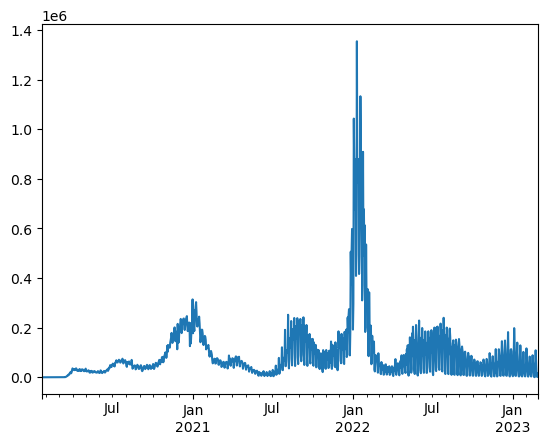

In [6]:
# Merging confirmed_df_long and deaths_df_long
full_table = confirmed_df_long.merge(
  right=deaths_df_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)
# Merging full_table and recovered_df_long
full_table = full_table.merge(
  right=recovered_df_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)
full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table['Recovered'] = full_table['Recovered'].fillna(0)
# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']
full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

# new cases 
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()
mask = temp['Country/Region'] != temp['Country/Region'].shift(1)
temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan
# renaming columns
temp.columns = ['Country/Region', 'Date', 'New cases', 'New deaths', 'New recovered']
# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])
# filling na with 0
full_grouped = full_grouped.fillna(0)
# fixing data types
cols = ['New cases', 'New deaths', 'New recovered']
full_grouped[cols] = full_grouped[cols].astype('int')
full_grouped['New cases'] = full_grouped['New cases'].apply(lambda x: 0 if x<0 else x)


# converting it into time series
data_ts = pd.Series(full_grouped['New cases'].values, index=pd.date_range(start=full_grouped['Date'][0], periods=len(full_grouped), freq='D'))
data_ts.plot()
plt.show()

# ADF Test
- Check for stationarity of the time series data using the Augmented Dickey-Fuller (ADF) test and plot the autocorrelation and partial autocorrelation functions.

In [7]:
result = adfuller(data_ts)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -4.326390359707482
p-value: 0.00039972100305956423
Critical Values: {'1%': -3.436260280202547, '5%': -2.864149693787122, '10%': -2.568159479632582}


# Data is staionary because p-value<0.05 so we can continue

- Draw ACF and PCAF graphs
- Print the summary of the ARIMA models

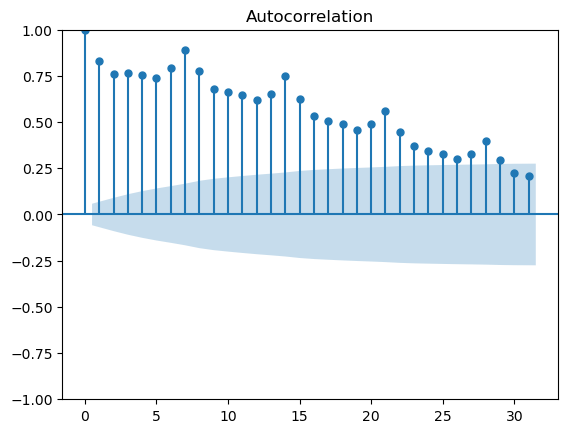

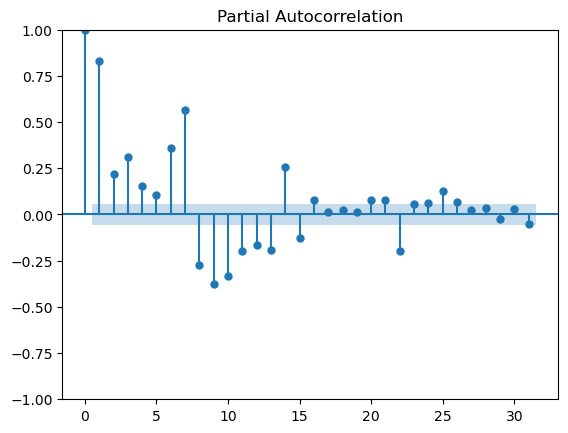

In [8]:
plot_acf(data_ts)
plt.show()
plot_pacf(data_ts)
plt.show()

# Print the summary of the ARIMA models

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1133
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -14153.135
Date:                Thu, 02 Mar 2023   AIC                          28314.270
Time:                        14:17:51   BIC                          28334.400
Sample:                    01-22-2020   HQIC                         28321.874
                         - 02-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.125e+04   1.46e-10   6.24e+14      0.000    9.13e+04    9.13e+04
ar.L1          0.9851      0.002    604.652      0.000       0.982       0.988
ma.L1         -0.6970      0.009    -77.259      0.0

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1133
Model:                 ARIMA(2, 0, 3)   Log Likelihood              -14170.536
Date:                Thu, 02 Mar 2023   AIC                          28355.072
Time:                        14:17:52   BIC                          28390.300
Sample:                    01-22-2020   HQIC                         28368.380
                         - 02-27-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.125e+04   6.33e-09   1.44e+13      0.000    9.13e+04    9.13e+04
ar.L1          0.4017      0.039     10.191      0.000       0.324       0.479
ar.L2          0.5768      0.040     14.395      0.0

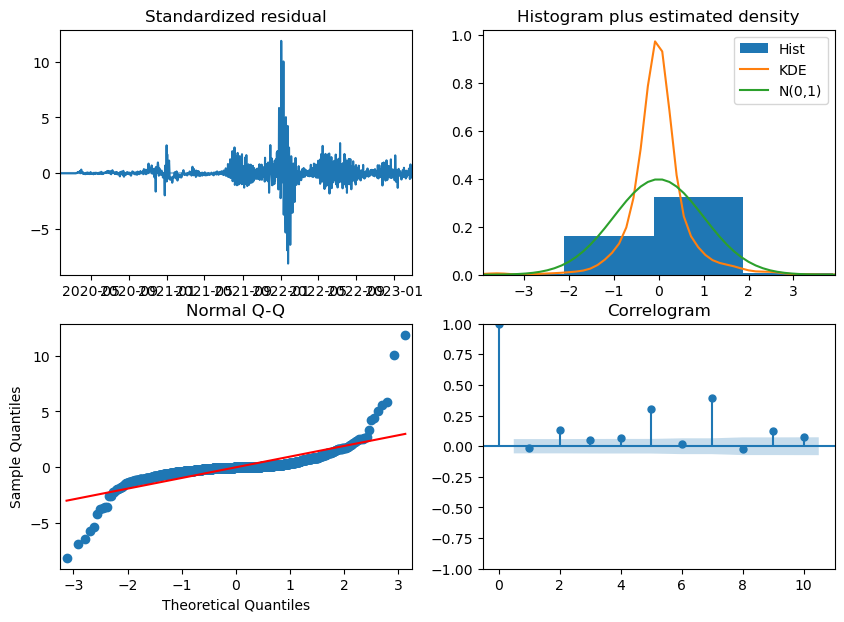

In [9]:


# ARIMA models
model1 = ARIMA(data_ts, order=(1, 0, 1)).fit()
print(model1.summary())

model2 = ARIMA(data_ts, order=(2, 0, 2)).fit()
print(model2.summary())

model3 = ARIMA(data_ts, order=(1, 0, 2)).fit()
print(model3.summary())

model4 = ARIMA(data_ts, order=(1, 0, 3)).fit()
print(model4.summary())

model5 = ARIMA(data_ts, order=(2, 0, 3)).fit()
print(model5.summary())

model_final = ARIMA(data_ts, order=(5, 1, 2)).fit()
print(model_final.summary())

model6 = auto_arima(data_ts,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,
                      stepwise=True)
#model6.fit(data_ts)
print(model6.summary())

model6.plot_diagnostics(figsize=(10,7))
plt.show()


# Compare hyperparameters

In [10]:
#Compare values for different hyperparameters

print(model1.aic, model1.bic, model1.hqic)
print(model2.aic, model2.bic, model2.hqic)
print(model3.aic, model3.bic, model3.hqic)
print(model4.aic, model4.bic, model4.hqic)
print(model5.aic, model5.bic, model5.hqic)
print(model_final.aic, model_final.bic, model_final.hqic)

28314.269589472206 28334.400086516318 28321.874068918318
28253.444126888986 28283.639872455155 28264.850846058154
28265.2307846389 28290.39390594404 28274.736383946543
28595.77885315666 28625.974598722827 28607.185572325827
28355.071869876396 28390.300239703593 28368.379708907094
27643.2047403306 27683.458670400705 27658.411690168632


# Parameters p,q,d selected with least value i-e, (5,1,2) selected as model

# Plot Fitted model

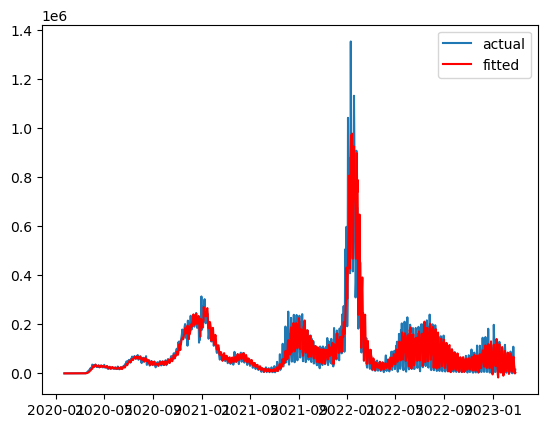

In [11]:
# plot the fitted model
plt.plot(data_ts, label='actual')
plt.plot(model_final.fittedvalues, color='red', label='fitted')
plt.legend()
plt.show()

# Forecast Future values from Model

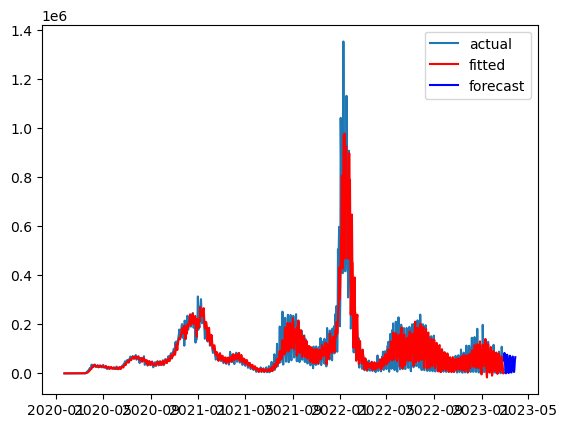

In [12]:
# predict future values
predictions = model_final.forecast(steps=30)
plt.plot(data_ts, label='actual')
plt.plot(model_final.fittedvalues, color='red', label='fitted')
plt.plot(predictions, color='blue', label='forecast')
plt.legend()
plt.show()

# Plot the residuals

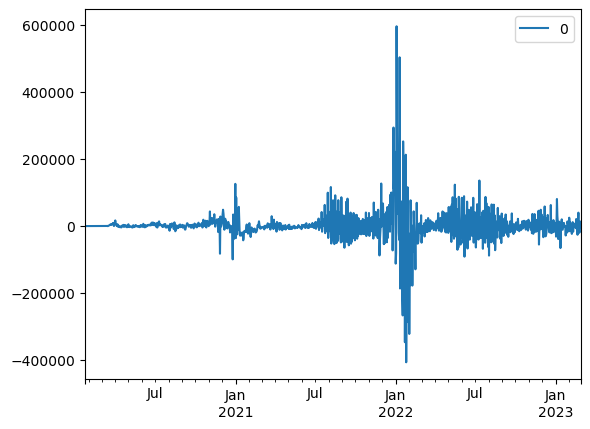

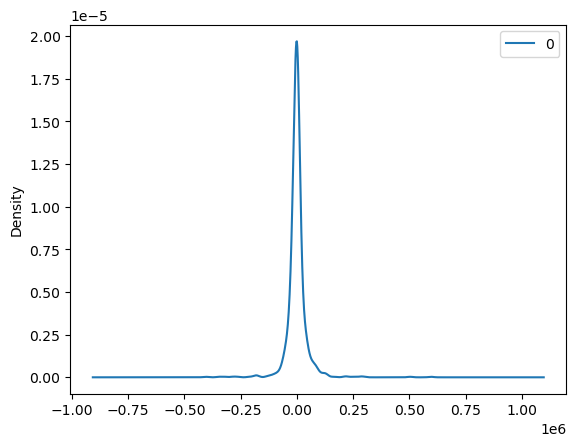

In [13]:


#print(predictions)

# check residuals
residuals = pd.DataFrame(model_final.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
#print(residuals.describe())




In [14]:
print(predictions)

2023-02-28    52274.373667
2023-03-01    83484.802975
2023-03-02    65795.470613
2023-03-03    25721.838100
2023-03-04      956.292814
2023-03-05      176.909558
2023-03-06    20331.328791
2023-03-07    55158.422638
2023-03-08    76213.423216
2023-03-09    62334.025010
2023-03-10    28005.423869
2023-03-11     2608.066964
2023-03-12     1185.850150
2023-03-13    23509.855875
2023-03-14    55355.634175
2023-03-15    72065.515322
2023-03-16    59339.816150
2023-03-17    28607.597156
2023-03-18     4390.605569
2023-03-19     3414.864507
2023-03-20    25609.777102
2023-03-21    54895.302664
2023-03-22    68931.424541
2023-03-23    56792.531392
2023-03-24    28591.359861
2023-03-25     6222.501743
2023-03-26     5885.795829
2023-03-27    27249.747389
2023-03-28    54183.278215
2023-03-29    66277.864824
Freq: D, Name: predicted_mean, dtype: float64
